In [1]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from itertools import product
import sys,time
import pickle
from scipy import sparse as sp
from scipy import sparse
from scipy.sparse import spdiags
from scipy.sparse import linalg
from scipy.sparse.linalg import spsolve
from scipy.io import savemat,loadmat
import scipy.integrate as integrate
import os
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from LaSDI import LaSDI

In [2]:
!nvidia-smi
torch.cuda.empty_cache()

Wed Sep 29 09:46:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.95.01    Driver Version: 440.95.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:04:00.0 Off |                    0 |
| N/A   41C    P0    54W / 300W |   1008MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000004:05:00.0 Off |                    0 |
| N/A   45C    P0    52W / 300W |   2535MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

# Discover Latent Space Dynamics

In [3]:
training_value = 7
LS_dim = 3
# ### Load Data if Model Already Exists ###
snapshot_full = np.array([])
Training_values = [.65,.75]
for i in Training_values:
    ex = np.load('./data/ex9_interp_{}.npz'.format(int(i*100)), allow_pickle = True)
    ex = ex.f.arr_0
    snapshot_full = np.append(snapshot_full, ex)
snapshot_full = snapshot_full.reshape(480,-1)
nx = 64
ny = 64
m = (ny-2)*(nx-2) # 3364
nt = 239
tstop = 3
dt = tstop/nt

In [4]:
snapshot_full.shape

(480, 4096)

In [5]:
multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
free_multi_index=(multi_index_j[1:-1,1:-1].flatten(),multi_index_i[1:-1,1:-1].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
free_raveled_indicies=np.ravel_multi_index(free_multi_index,dims)

snapshot_full = snapshot_full[:,free_raveled_indicies]

[xv,yv]=np.meshgrid(np.linspace(-1,1,nx),np.linspace(-1,1,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

x_free=x[free_raveled_indicies]
y_free=y[free_raveled_indicies]

In [6]:
# Choose device that is not being used
gpu_ids = "1"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device, '\n')
%cd
model = torch.load('../../../../../usr/WS1/fries4/Experiments/EX9/model/ex9_AE_git_single.tar', map_location=device)    

maxk = 10
convergence_threshold = 1.0e-8

t = np.linspace(0, tstop, nt)

# set the number of nodes in each layer
a = 2
b = int(100)
db = int(10)

M1 = int(a*m) # encoder hidden layer
M2 = b + (m-1)*db # decoder hidden layer
f = LS_dim


def create_mask_2d(m,b,db):

    # local
    Mb=sp.diags([np.ones(nx-2),np.ones(nx-2),np.ones(nx-2)],[0,-1,1],(nx-2,nx-2))
    M=sp.kron(sp.eye(ny-2),Mb,format="csr")

    Ib=sp.eye(nx-2)
    N=sp.kron(sp.diags([np.ones(ny-2),np.ones(ny-2),np.ones(ny-2)],[0,-1,1],(ny-2,ny-2)),Ib,format="csr")

    local=(M+N).astype('int8')
    I,J,V=sp.find(local)
    local[I,J]=1

#     col_ind=np.array([],dtype='int')
#     row_ind=np.array([],dtype='int')

#     for lin_ind in range(m):
#         j,i=np.unravel_index(lin_ind,(ny-2,nx-2))

#         E=np.ravel_multi_index((j,np.max((i-1,0))),(ny-2,nx-2))
#         W=np.ravel_multi_index((j,np.min((i+1,nx-2-1))),(ny-2,nx-2))
#         S=np.ravel_multi_index((np.max((j-1,0)),i),(ny-2,nx-2))
#         N=np.ravel_multi_index((np.min((j+1,ny-2-1)),i),(ny-2,nx-2))

#         col=np.unique([lin_ind,E,W,S,N])
#         row=lin_ind*np.ones(col.size,dtype='int')

#         col_ind=np.append(col_ind,col)
#         row_ind=np.append(row_ind,row)

#     data=np.ones(row_ind.size,dtype='int')
#     local2=sp.csr_matrix((data,(row_ind,col_ind)),shape=(m,m))

    # basis
    M2 = int(b + db*(m-1))
    basis = np.zeros((m,M2),dtype='int8')

    block = np.ones(b,dtype='int8')
    ind = np.arange(b)
    for row in range(m):
        col = ind + row*db
        basis[row,col] = block

    # mask
    col_ind=np.array([],dtype='int8')
    row_ind=np.array([],dtype='int8')
    for i in range(m):
        col=basis[sp.find(local[i])[1]].sum(axis=0).nonzero()[0]
        row=i*np.ones(col.size)

        col_ind=np.append(col_ind,col)
        row_ind=np.append(row_ind,row)

    data=np.ones(row_ind.size,dtype='int8')
    mask=sp.csr_matrix((data,(row_ind,col_ind)),shape=(m,M2)).toarray()

    print(
        "Sparsity in {} by {} mask: {:.2f}%".format(
            m, M2, (1.0-np.count_nonzero(mask)/np.prod(mask.shape))*100
        )
    )

#         plt.figure()
#         plt.spy(mask)
#         plt.show()

    return mask



class Encoder(nn.Module):
    def __init__(self,m,M1,f):
        super(Encoder,self).__init__()
        self.full = nn.Sequential(
            nn.Linear(m,M1),
            nn.Sigmoid(),
            nn.Linear(M1,f,bias=False)
        )

    def forward(self, y):     
        y = y.view(-1,m)
        T = self.full(y)
        T = T.squeeze()

        return T

class Decoder(nn.Module):
    def __init__(self,f,M2,m):
        super(Decoder,self).__init__()
        self.full = nn.Sequential(
            nn.Linear(f,M2),
            nn.Sigmoid(),
            nn.Linear(M2,m,bias=False)
        )

    def forward(self,T):
        T = T.view(-1,f)
        y = self.full(T)
        y = y.squeeze()

        return y

encoder = Encoder(m,M1,f).to(device)
decoder = Decoder(f,M2,m).to(device)
# Prune
mask_2d=create_mask_2d(m,b,db)
prune.custom_from_mask(decoder.full[2], name='weight', mask=torch.tensor(mask_2d).to(device))  

loss_func = nn.MSELoss(reduction='mean')

encoder.load_state_dict(model['encoder_state_dict'])
decoder.load_state_dict(model['decoder_state_dict'])

Using device: cuda 

/g/g15/fries4
Sparsity in 3844 by 38530 mask: 99.18%


<All keys matched successfully>

In [7]:
amp_arr = np.linspace(.65,.75, training_value)
width_arr = np.array([1])

P = list(product(amp_arr, width_arr))
P = np.array(P)

ndata = snapshot_full.shape[0]
nset = int(ndata/(nt+1))

latent_space_SS = []

for foo in range(nset):
    input_SS=torch.tensor(snapshot_full[foo*(nt+1):(foo+1)*(nt+1)].astype('float32')).to(device)
    latent_space = encoder(input_SS).cpu().detach().numpy()
    latent_space_SS.append(latent_space)

/g/g15/fries4/GitHub/NM-ROM/nm-rom/lib/python3.7/site-packages/scikit_learn-0.24.2-py3.7-linux-ppc64le.egg/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.05689e-08): result may not be accurate.
  overwrite_a=True).T
/g/g15/fries4/GitHub/NM-ROM/nm-rom/lib/python3.7/site-packages/scikit_learn-0.24.2-py3.7-linux-ppc64le.egg/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.05689e-08): result may not be accurate.
  overwrite_a=True).T
/g/g15/fries4/GitHub/NM-ROM/nm-rom/lib/python3.7/site-packages/scikit_learn-0.24.2-py3.7-linux-ppc64le.egg/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.05689e-08): result may not be accurate.
  overwrite_a=True).T


x0' = -8.386 1 + 42.604 x0 + 0.040 x1 + 0.890 x2 + -72.844 x0^2 + 0.586 x1^2 + -2.071 x2^2 + 41.167 x0^3 + 0.274 x1^3 + 1.124 x2^3
x1' = -10.174 1 + 58.652 x0 + -0.302 x1 + 0.387 x2 + -111.373 x0^2 + 0.379 x1^2 + 1.179 x2^2 + 69.747 x0^3 + 0.590 x1^3 + -0.835 x2^3
x2' = 1.825 1 + 10.002 x0 + -0.586 x1 + -3.146 x2 + -39.257 x0^2 + -1.001 x1^2 + 8.725 x2^2 + 32.128 x0^3 + -0.172 x1^3 + -7.832 x2^3


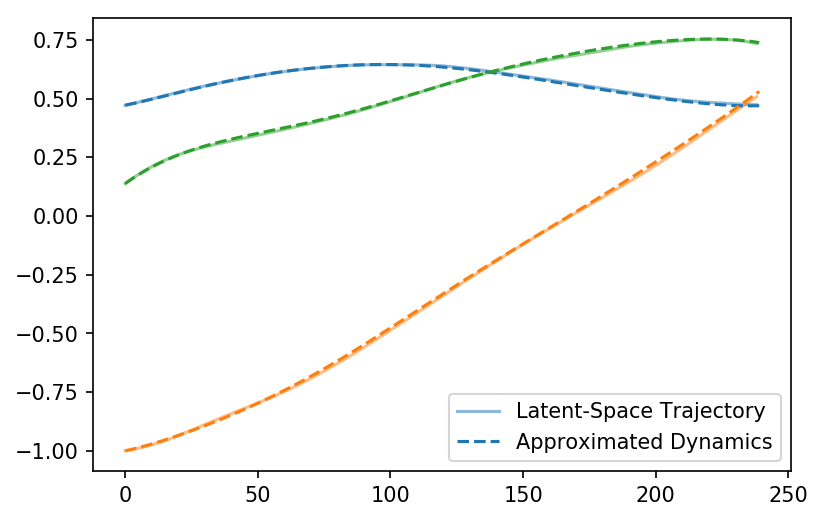

In [42]:
degree = 3
LaSDI_model = LaSDI(encoder, decoder, NN = True, device = 'cuda')
normal = np.amax(np.abs(latent_space_SS))
LaSDI_model.train_dynamics(latent_space_SS, P, dt, degree = degree, normal = normal, include_interaction = False)

In [43]:
FOM_file = np.load('../../../../../usr/WS1/fries4/Experiments/EX9/data/Interp_Extrap/ex9_70.p', allow_pickle = True)
FOM = FOM_file['FOM']
FOM = FOM[:,free_raveled_indicies]
time_FOM = FOM_file['t']
start = time.time()
FOM_recon = LaSDI_model.generate_FOM(FOM[0], np.array([0.7,1.0]),t)
LaSDI_time = time.time()-start
speed_up = time_FOM/LaSDI_time
test = []
for k in range(int(nt)):
    test.append(LA.norm(FOM_recon[k].reshape(ny-2,nx-2)-FOM[k].reshape(ny-2,nx-2))/LA.norm(FOM[k].reshape(ny-2,nx-2))*100)
max_re = np.amax(test)

In [44]:
FOM_recon.shape

(239, 3844)

Text(0.5, 1.0, 'Relative Error: 5.23%  Speedup: 1.8e+02 times')

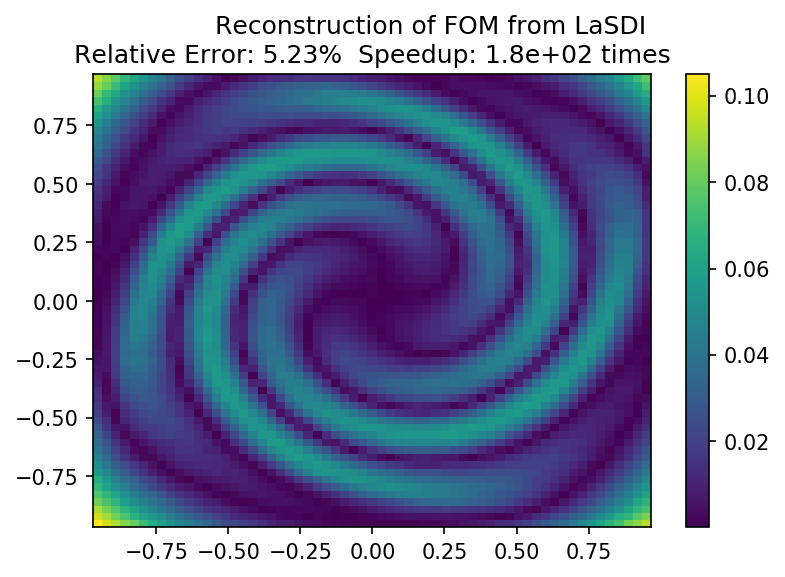

In [45]:
fig = plt.figure()
ax = plt.axes()
z=ax.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),np.abs(FOM_recon[-1].reshape(nx-2,ny-2)-FOM[-1].reshape(nx-2,ny-2)), shading = 'nearest')
fig.colorbar(z,ax = ax)
fig.suptitle('Reconstruction of FOM from LaSDI')
ax.set_title('Relative Error: {:.3}%  Speedup: {:.3} times'.format(LA.norm(FOM_recon[-1]-FOM[-1])/LA.norm(FOM[-1])*100, time_FOM/LaSDI_time))

In [ ]:
torch.cuda.empty_cache()

Text(0.5, 1.0, 'Absolute Error')

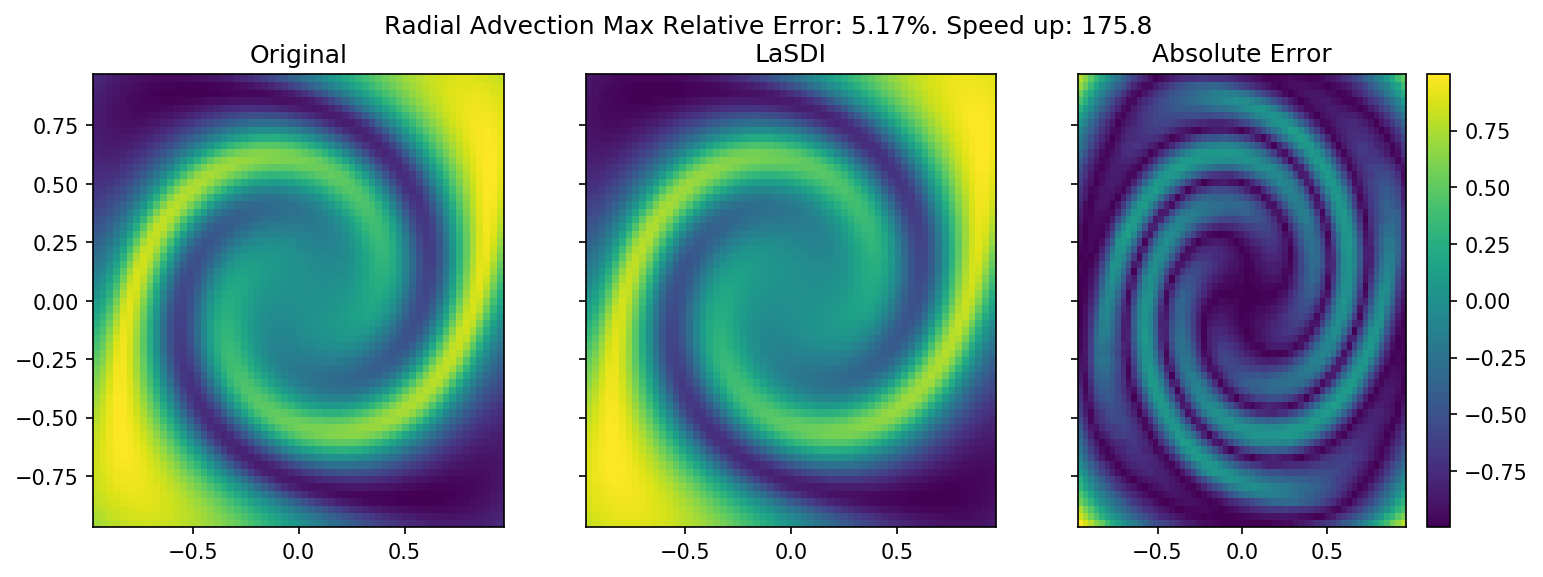

In [67]:
k = -1
plt.rcParams['figure.dpi'] = 150
# plt.figure(figsize=(8, 6), dpi=80)
fig, (ax1,ax2,ax3) = plt.subplots(1,3,sharey = True)
fig.set_size_inches(12,4)

# ax1 = fig.add_subplot(2,3,1)
z=ax1.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),FOM[k].reshape(nx-2,ny-2), shading = 'nearest')
# fig.colorbar(z, ax = ax1)
fig.suptitle('Radial Advection Max Relative Error: {:.2f}%. Speed up: {:.1f}'.format(np.amax(max_re), speed_up))
ax1.set_title('Original')
# ax1.set_ylabel('U')

# ax2 = fig.add_subplot(2,3,2)
z1=ax2.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),FOM_recon[k].reshape(nx-2,ny-2), shading = 'nearest')
# fig.colorbar(z, ax = ax2)
ax2.set_title('LaSDI')

# ax3 = fig.add_subplot(2,3,3)
z2=ax3.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),np.abs(FOM_recon[k].reshape(nx-2,ny-2)-FOM[k].reshape(nx-2,ny-2)), shading = 'nearest')
fig.colorbar(z, ax = ax3)
ax3.set_title('Absolute Error')

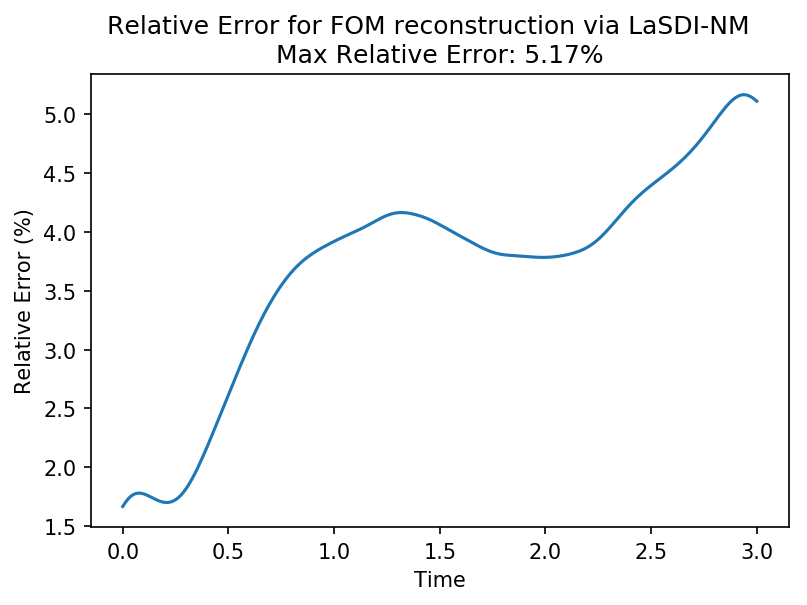

In [72]:
fig = plt.figure()
fig.suptitle('Relative Error for FOM reconstruction via LaSDI-NM')
ax = plt.axes()
ax.set_title('Max Relative Error: {:.3}%'.format(np.amax(test)))
ax.plot(t, test)
ax.set_xlabel('Time')
ax.set_ylabel('Relative Error (%)')
torch.cuda.empty_cache()